In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Model, load_model
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import (mean_absolute_percentage_error,
                             mean_squared_error, r2_score)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm

In [2]:
X, y = fetch_california_housing(return_X_y=True)
n = len(X)//10
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=n, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=n, random_state=42)
X_train.shape, y_val.shape, y_test.shape

scaler = MinMaxScaler()
scaler.fit(X_train)
X_dev_scaled = scaler.transform(X_dev)
X_test_scaled = scaler.transform(X_test)

In [3]:
def evaluate_model(X_dev, y_dev, X_test, y_test,
    model, param_grid, scalar=None, *args, **kwargs):
    reg = model(*args, **kwargs)
    scalar_step = [] if scalar is None else [('scale', scalar)]
    pipe = Pipeline(steps=scalar_step+[('reg', reg)])
    search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
    search.fit(X_dev, y_dev)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)
    
    y_pred = search.predict(X_test)
    return (search,
            mean_absolute_percentage_error(y_test, y_pred),
            np.sqrt(mean_squared_error(y_test, y_pred)),
            r2_score(y_test, y_pred))

In [4]:
def annotate_bars(ax, horizontal=True, scale=1):
    for p in ax.patches:
        if horizontalal:
            xpos = p.get_width()+ p.get_width()*0.01*scale
            ax.annotate(f"{round(p.get_width(), 3)}", (xpos, p.get_y() +0.1), fontsize=14)
        else:
            ypos = p.get_height()+ p.get_height()*0.01*scale
            ax.annotate(f"{round(p.get_height(), 3)}", (p.get_x() +p.get_width()/2, ypos), fontsize=14)
    return ax

In [5]:
np.arange(70, 311, 30)

array([ 70, 100, 130, 160, 190, 220, 250, 280, 310])

In [6]:
models = {
    "Ridge Regression": {
        "instance": Ridge,
        "param_grid": {"reg__alpha": np.arange(0.1, 1.1, 0.1)},
        "scalar": MinMaxScaler(),
        "parameters": {"random_state":42}
    },
    "MLP": {
        "instance": MLPRegressor,
        "param_grid": {"reg__hidden_layer_sizes": [[16], [16, 16], [16, 16, 16]]},
        "scalar": MinMaxScaler(),
        "parameters": {"max_iter": 1000, "random_state":42}
    },
    "Random Forest": {
        "instance": RandomForestRegressor,
        "scalar": None,
        "param_grid": {"reg__n_estimators": np.arange(70, 310, 30)},
        "parameters": {"random_state":42}
    },
    "AdaBoost":{
        "instance": AdaBoostRegressor,
        "scalar": None,
        "param_grid": {"reg__n_estimators": np.arange(70, 310, 30), 
                       "reg__loss":['linear', 'square', 'exponential']
                      },
        "parameters": {"random_state":42}
    },
    "SVM": {
        "instance": SVR,
        "scalar": MinMaxScaler(),
        "param_grid": {
            "reg__C": np.arange(0.1, 1.1, 0.1),
            "reg__kernel": ["rbf", "linear", "poly", "sigmoid"]
        }, "parameters": {}
    }
}


In [7]:
def plot_performance(reports, features=["MAPE", "RMSE", "R2"]):
    plt.figure(figsize=(16, 9))
    performance = pd.DataFrame(reports).T[features]
    ax = performance.plot(kind="barh", figsize=(16, 9), fontsize=16)
    ax = annotate_bars(ax, horizontal=True)
    plt.show()

In [8]:
def find_best(X_dev, y_dev, X_test, y_test):
    global models
    reports = {}
    for model_name, model_attributes in tqdm(models.items()):
        print(model_name)
        estimator = model_attributes["instance"]
        param_grid = model_attributes["param_grid"]
        parameters = model_attributes["parameters"]
        scalar = model_attributes["scalar"]

        trained_model, mape, rmse, r2 = evaluate_model(
            X_dev, y_dev, X_test, y_test,
            estimator,
            param_grid=param_grid,
            scalar=scalar,
            ** parameters
        )
        reports[model_name] = {
            "model": trained_model, "MAPE": mape, "RMSE": rmse, "R2": r2}
        print()
    return reports

# Loading Target Estimation Model

In [9]:
model = load_model("cal_house")

2022-02-02 09:21:36.697387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 09:21:36.719316: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 09:21:36.719443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 09:21:36.719961: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
yhat_dev = model.predict(X_dev_scaled).flatten()
yhat_test = model.predict(X_test_scaled).flatten()

2022-02-02 09:21:37.816008: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


# Computing Error Vectors

In [11]:
e_dev = y_dev-yhat_dev
e_test = y_test-yhat_test

# Finding best Error Estimation Model

In [12]:
X_dev_yhat = np.concatenate((X_dev, yhat_dev.reshape(-1, 1)), axis=1)

X_test_yhat = np.concatenate((X_test, yhat_test.reshape(-1, 1)), axis=1)

In [13]:
reports_ee = find_best(X_dev_yhat, e_dev, X_test_yhat, e_test)

  0%|                                                     | 0/5 [00:00<?, ?it/s]

Ridge Regression


 20%|█████████                                    | 1/5 [00:00<00:03,  1.11it/s]

Best parameter (CV score=0.000):
{'reg__alpha': 1.0}

MLP


 40%|██████████████████                           | 2/5 [00:05<00:09,  3.13s/it]

Best parameter (CV score=0.010):
{'reg__hidden_layer_sizes': [16, 16, 16]}

Random Forest


 60%|███████████████████████████                  | 3/5 [01:23<01:14, 37.06s/it]

Best parameter (CV score=0.249):
{'reg__n_estimators': 250}

AdaBoost


 80%|████████████████████████████████████         | 4/5 [01:37<00:28, 28.20s/it]

Best parameter (CV score=-0.604):
{'reg__loss': 'linear', 'reg__n_estimators': 70}

SVM
Best parameter (CV score=0.006):
{'reg__C': 1.0, 'reg__kernel': 'rbf'}


100%|█████████████████████████████████████████████| 5/5 [05:53<00:00, 70.61s/it]

In [14]:
pd.DataFrame(reports_ee).T.drop("model", axis="columns")[["R2", "MAPE", "RMSE"]]

,R2,MAPE,RMSE
Ridge Regression,0.001916,2.160034,0.550805
MLP,0.005361,5.888053,0.549854
Random Forest,0.295026,4.961458,0.462915
AdaBoost,-0.542001,99.054771,0.684631
SVM,0.017023,8.974913,0.54662


<Figure size 1152x648 with 0 Axes>

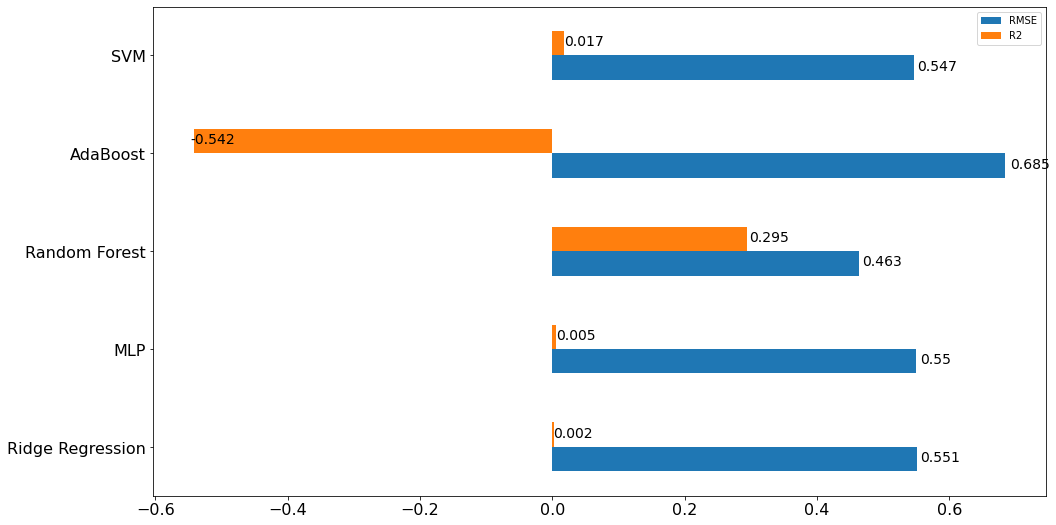

In [15]:
plot_performance(reports_ee, features=["RMSE", "R2"])

In [16]:
best_ee = reports_ee["Random Forest"]["model"]
best_ee

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('reg',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'reg__n_estimators': array([ 70, 100, 130, 160, 190, 220, 250, 280])})

# Correcting TE with EE
Since...
$$y=\hat{y} + \epsilon$$
Therefore...
$$\hat{y}_{\text{corrected}}=\hat{y} + \lambda \cdot\hat{\epsilon}$$
Where $\lambda$ is a scalar constant. With lower values of $c$ you are more assured you are getting closer to the actual result. However, with higher values of $\lambda$ you might be over correcting for $y$ and end up with more error.

In [21]:
def correct_te_with_ee(X, yhat, lamda):
    e = best_ee.predict(np.concatenate((X, yhat.reshape(-1, 1)), axis=1))
    return yhat + lamda*e

def evaluation_report(y, yhat):
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    r2 = r2_score(y, yhat)
    return mape, rmse, r2

Finding the best $\lambda$ on the training data.

In [22]:
from joblib import Parallel, delayed

In [23]:
def step(lamda):
    corrected_yhat = correct_te_with_ee(X_dev, yhat_dev, lamda)
    mape, rmse, r2 = evaluation_report(y_dev, corrected_yhat)
    return mape, rmse, r2

In [24]:
report = Parallel(n_jobs=-1, backend="threading")(delayed(step)(lamda) for lamda in np.arange(-2, 2.01, 0.01))

In [25]:
report_df = pd.DataFrame(report, columns=["MAPE", "RMSE", "R2"]).assign(lamda=np.arange(-2, 2.01, 0.01))
report_df

,MAPE,RMSE,R2,lamda
0,0.525938,1.302646,-0.274587,-2.00
1,0.524341,1.298763,-0.267001,-1.99
2,0.522745,1.294881,-0.259438,-1.98
3,0.521149,1.290999,-0.251897,-1.97
4,0.519553,1.287117,-0.244380,-1.96
...,...,...,...,...
396,0.117743,0.266304,0.946731,1.96
397,0.119224,0.269881,0.945291,1.97
398,0.120710,0.273467,0.943827,1.98
399,0.122200,0.277061,0.942341,1.99


In [26]:
best_lamda = report_df.sort_values("R2", ascending=False).iloc[0].lamda
best_lamda

1.3300000000000027

In [27]:
corrected_yhat = correct_te_with_ee(X_test, yhat_test, best_lamda)
mape, rmse, r2 = evaluation_report(y_test, corrected_yhat)
mape, rmse, r2

(0.16151997448271135, 0.4592927211427525, 0.841820393236792)

# Significance Test

In [28]:
pd.DataFrame([evaluation_report(y_test, yhat_test), evaluation_report(y_test, corrected_yhat)], columns=["MAPE","RMSE", "R2"], index=["Before", "After"])

,MAPE,RMSE,R2
Before,0.211691,0.551333,0.772071
After,0.161520,0.459293,0.841820


In [29]:
from scipy.stats import ttest_ind

In [30]:
old = np.abs((y_test-yhat_test)/y_test)
new = np.abs((y_test-corrected_yhat)/y_test)

In [31]:
ttest_ind(new, old, alternative='less')

Ttest_indResult(statistic=-6.97419201605633, pvalue=1.7835927065047248e-12)